In [2]:
# Include Libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,\
   Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10

In [3]:
# Test and Train dataset
(train_data_clean, _), (test_data_clean, _) = cifar10.load_data()

In [4]:
train_data_clean = train_data_clean.astype('float32') / 255.
test_data_clean = test_data_clean.astype('float32') / 255.

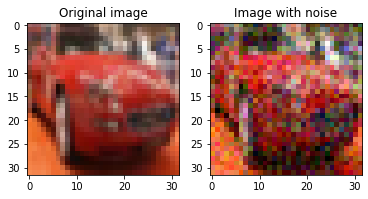

In [5]:
# Adding Noise to the dataset
def add_noise_and_clip_data(data):
   noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
   data = data + noise
   data = np.clip(data, 0., 1.)
   return data

train_data_noisy = add_noise_and_clip_data(train_data_clean)
test_data_noisy = add_noise_and_clip_data(test_data_clean)

index = 5
plt.subplot(1,2,1)
plt.imshow(train_data_clean[index])
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(train_data_noisy[index])
plt.title('Image with noise')
plt.show()

In [6]:
# Model structure
def conv_block(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

def deconv_block(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

In [7]:
def denoising_autoencoder():
   dae_inputs = Input(shape=(32, 32, 3), name='dae_input')
   conv_block1 = conv_block(dae_inputs, 32, 3)
   conv_block2 = conv_block(conv_block1, 64, 3)
   conv_block3 = conv_block(conv_block2, 128, 3)
   conv_block4 = conv_block(conv_block3, 256, 3)
   conv_block5 = conv_block(conv_block4, 256, 3, 1)

   deconv_block1 = deconv_block(conv_block5, 256, 3)
   merge1 = Concatenate()([deconv_block1, conv_block3])
   deconv_block2 = deconv_block(merge1, 128, 3)
   merge2 = Concatenate()([deconv_block2, conv_block2])
   deconv_block3 = deconv_block(merge2, 64, 3)
   merge3 = Concatenate()([deconv_block3, conv_block1])
   deconv_block4 = deconv_block(merge3, 32, 3)

   final_deconv = Conv2DTranspose(filters=3,
                       kernel_size=3,
                       padding='same')(deconv_block4)

   dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)
  
   return Model(dae_inputs, dae_outputs, name='dae')

In [8]:
dae = denoising_autoencoder()
dae.compile(loss='mse', optimizer='adam')

checkpoint = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)

dae.fit(train_data_noisy,
       train_data_clean,
       validation_data=(test_data_noisy, test_data_clean),
       epochs=40,
       batch_size=128,
       callbacks=[checkpoint])

Epoch 1/40
391/391 [==============================] - ETA: 0s - loss: 0.0045
Epoch 00001: val_loss improved from inf to 0.00481, saving model to best_model.h5
391/391 [==============================] - 41s 106ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 2/40
391/391 [==============================] - ETA: 0s - loss: 0.0024
Epoch 00002: val_loss improved from 0.00481 to 0.00220, saving model to best_model.h5
391/391 [==============================] - 38s 98ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 3/40
391/391 [==============================] - ETA: 0s - loss: 0.0022
Epoch 00003: val_loss improved from 0.00220 to 0.00210, saving model to best_model.h5
391/391 [==============================] - 37s 96ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 4/40
391/391 [==============================] - ETA: 0s - loss: 0.0021
Epoch 00004: val_loss improved from 0.00210 to 0.00195, saving model to best_model.h5
391/391 [==============================] - 37s 95ms/step - loss: 0.0021 - val_

Epoch 36/40
391/391 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00036: val_loss did not improve from 0.00153
391/391 [==============================] - 41s 106ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 37/40
391/391 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00037: val_loss did not improve from 0.00153
391/391 [==============================] - 42s 107ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 38/40
391/391 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00038: val_loss did not improve from 0.00153
391/391 [==============================] - 41s 105ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 39/40
391/391 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00039: val_loss did not improve from 0.00153
391/391 [==============================] - 39s 100ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 40/40
391/391 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00040: val_loss did not improve 

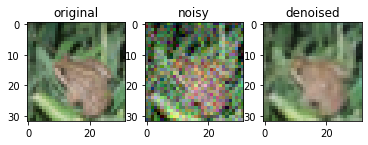

In [9]:
dae.load_weights('best_model.h5')
test_data_denoised = dae.predict(test_data_noisy)
idx = 4
plt.subplot(1,3,1)
plt.imshow(test_data_clean[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(test_data_noisy[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(test_data_denoised[idx])
plt.title('denoised')
plt.show()